# Traffic Light Detection and Color Recognition

## Import Important Libraries

In [1]:
### Import Important Libraries

import numpy as np
import os
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from os import path
from utils import label_map_util
from utils import visualization_utils as vis_util
import time
import cv2


## Function To Detect Red and Yellow Color
Here,we are detecting only Red and Yellow colors for the traffic lights as we need to stop the car when it detects these colors. 

In [2]:
def detect_red_and_yellow(img, Threshold=0.01):
    """
    detect red and yellow
    :param img:
    :param Threshold:
    :return:
    """

    desired_dim = (30, 90)  # width, height
    img = cv2.resize(np.array(img), desired_dim, interpolation=cv2.INTER_LINEAR)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red1 = np.array([170, 70, 50])
    upper_red1 = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)

    # defining the Range of yellow color
    lower_yellow = np.array([21, 39, 64])
    upper_yellow = np.array([40, 255, 255])
    mask2 = cv2.inRange(img_hsv, lower_yellow, upper_yellow)

    # red pixels' mask
    mask = mask0 + mask1 + mask2

    # Compare the percentage of red values
    rate = np.count_nonzero(mask) / (desired_dim[0] * desired_dim[1])

    if rate > Threshold:
        return True
    else:
        return False

## Loading Image Into Numpy Array

In [3]:

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

## Read Traffic Light objects 
Here,we will write a function to detect TL objects and crop this part of the image to recognize color inside the object. We will create a stop flag,which we will use to take the actions based on recognized color of the traffic light.

In [4]:

def read_traffic_lights_object(image, boxes, scores, classes, max_boxes_to_draw=20, min_score_thresh=0.5,
                               traffic_ligth_label=10):
    im_width, im_height = image.size
    stop_flag = False
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores[i] > min_score_thresh and classes[i] == traffic_ligth_label:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            crop_img = image.crop((left, top, right, bottom))

            if detect_red_and_yellow(crop_img):
                stop_flag = True

    return stop_flag



## Function to Plot detected image

In [5]:
def plot_origin_image(image_np, boxes, classes, scores, category_index):
    # Size of the output images.
    IMAGE_SIZE = (12, 8)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        min_score_thresh=.5,
        use_normalized_coordinates=True,
        line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

    # save augmented images into hard drive
    # plt.savefig( 'output_images/ouput_' + str(idx) +'.png')
    plt.show()

## Function to Detect Traffic Lights and to Recognize Color

In [6]:
def detect_traffic_lights(PATH_TO_TEST_IMAGES_DIR, MODEL_NAME, Num_images, plot_flag=False):
    """
    Detect traffic lights and draw bounding boxes around the traffic lights
    :param PATH_TO_TEST_IMAGES_DIR: testing image directory
    :param MODEL_NAME: name of the model used in the task
    :return: commands: True: go, False: stop
    """

    # --------test images------
    TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'img_{}.jpg'.format(i)) for i in range(1, Num_images + 1)]

    commands = []

    # What model to download
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = 'mscoco_label_map.pbtxt'

    # number of classes for COCO dataset
    NUM_CLASSES = 90

    # --------Download model----------
    if path.isdir(MODEL_NAME) is False:
        opener = urllib.request.URLopener()
        opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
        tar_file = tarfile.open(MODEL_FILE)
        for file in tar_file.getmembers():
            file_name = os.path.basename(file.name)
            if 'frozen_inference_graph.pb' in file_name:
                tar_file.extract(file, os.getcwd())

    # --------Load a (frozen) Tensorflow model into memory
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    # ---------Loading label map
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map,
                                                                max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            for image_path in TEST_IMAGE_PATHS:
                image = Image.open(image_path)

                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})

                stop_flag = read_traffic_lights_object(image, np.squeeze(boxes), np.squeeze(scores),
                                                       np.squeeze(classes).astype(np.int32))
                if stop_flag:
                    # print('{}: stop'.format(image_path))  # red or yellow
                    commands.append(False)
                    cv2.putText(image_np, 'Stop', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
                else:
                    # print('{}: go'.format(image_path))
                    commands.append(True)
                    cv2.putText(image_np, 'Go', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

                # Visualization of the results of a detection.
                if plot_flag:
                    plot_origin_image(image_np, boxes, classes, scores, category_index)

    return commands

## Let's detect Traffic lights in test_images directory 

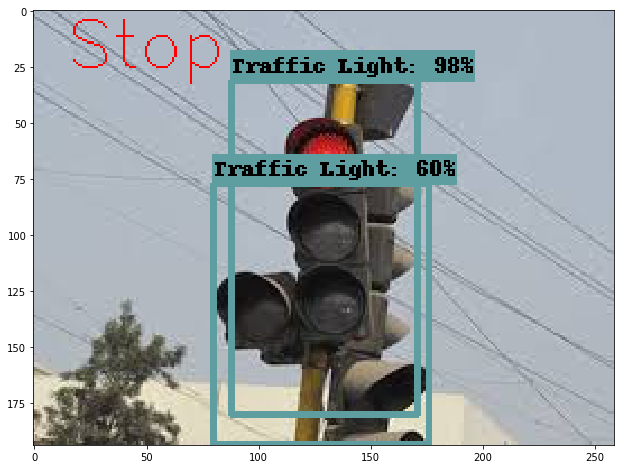

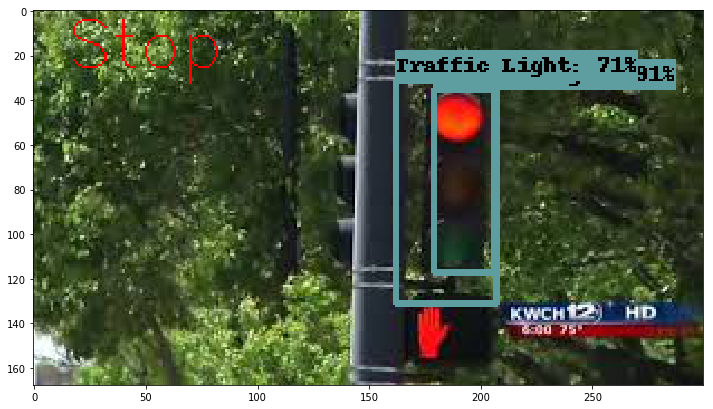

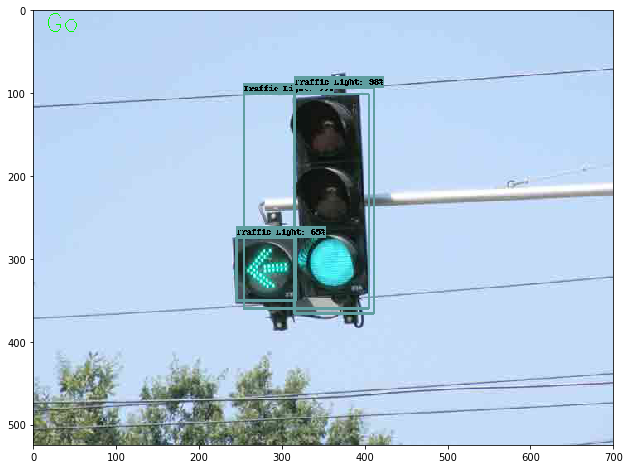

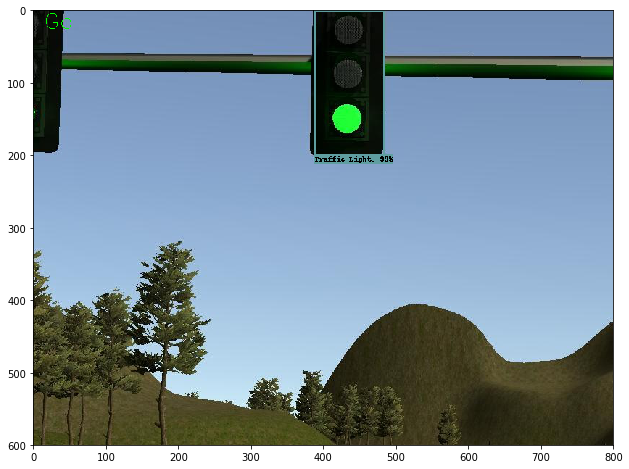

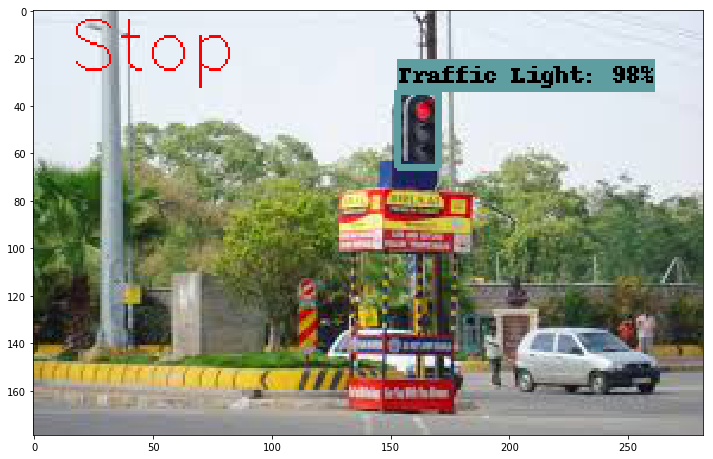

[False, False, True, True, False]


In [7]:
if __name__ == "__main__":
    # Specify number of images to detect
    Num_images = 5

    # Specify test directory path
    PATH_TO_TEST_IMAGES_DIR = './test_images'

    # Specify downloaded model name
    # MODEL_NAME ='ssd_mobilenet_v1_coco_11_06_2017'    # for faster detection but low accuracy
    MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'  # for improved accuracy

    commands = detect_traffic_lights(PATH_TO_TEST_IMAGES_DIR, MODEL_NAME, Num_images, plot_flag=True)
    print(commands)  # commands to print action type, for 'Go' this will return True and for 'Stop' this will return False

